In [1]:

#pip install mitosheet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# reading csv files

iaps=pd.read_csv('iaps.csv')
display('iaps', iaps.head(2))


Users=pd.read_csv('users.csv')
display('Users', Users.head(2))

Sessions=pd.read_csv('sessions.csv')
display('sessions', Sessions.head(2))

Spend_Events=pd.read_csv('spendevents.csv')
display('Spend_Events', Spend_Events.head(2))


'iaps'

,user_id,ts,date,prod_name,prod_type,rev
0,7480,2019-03-04 08:15:49,2019-03-04,iap_1_gems_2,gems,760
1,7480,2019-03-04 08:24:15,2019-03-04,iap_1_passes_2,chapterPasses,760


'Users'

,user_id,install_date,lang,country,hw_ver,os_ver
0,0,2019-03-01,en,US,"iPhone4,1",9.1
1,1,2019-03-01,en,IN,"iPod5,1",8.1.2


'sessions'

,user_id,ts,date,session_num,last_session_termination_type
0,14067,2019-03-01 00:06:50,2019-03-01,1,NaN
1,14067,2019-03-01 00:22:27,2019-03-01,2,NaN


'Spend_Events'

,user_id,ts,date,story,chapter,spendtype,currency,amount
0,9829,2019-03-01 03:03:04,2019-03-01,story_1,0.0,earnGemsCounter,gems,-22.0
1,13757,2019-03-01 03:35:53,2019-03-01,story_1,0.0,earnGemsCounter,gems,-22.0


In [3]:
# Users

n_users=Users.user_id.nunique()
print ('Number of Users: ', n_users, '\n')


n_paid_users=iaps.user_id.nunique()
print ('Number paid users: ', n_paid_users, '\n')

# percentage of paid user 
Paid_user_percentage= n_paid_users/n_users *100

print ('percentage of paid user: {:0.2f}%'.format(Paid_user_percentage), '\n')

Number of Users:  22576 

Number paid users:  1526 

percentage of paid user: 6.76% 



In [4]:
#Revenue per product Type
Rev_per_type=pd.DataFrame(iaps.groupby(['user_id','prod_type']).rev.sum())
display(Rev_per_type.head())

rev
user_id prod_type          
2       gems            760
21      chapterPasses  1520
        gems            760
36      chapterPasses  1810
        gems           2750

In [5]:
# pivot table revenue per product for each user 
rev_per_product=pd.pivot_table(iaps, index='user_id', columns='prod_type', values='rev', aggfunc=sum)
rev_per_product=pd.DataFrame(rev_per_product)
rev_per_product.columns=['chapterPasses', 'gems', 'valuePack']
rev_per_product.fillna(0, inplace=True)
rev_per_product.head()

,chapterPasses,gems,valuePack
user_id,,,
2,0.0,760.0,0.0
21,1520.0,760.0,0.0
36,1810.0,2750.0,0.0
51,1580.0,4970.0,0.0
85,0.0,760.0,0.0


In [6]:
#Total Revenue per Month
iaps.date=pd.to_datetime(iaps.date)
Revenue_per_Month=iaps.resample('M', on='date').sum()
Revenue_per_Month.iloc[:,1]

date
2019-03-31    6733665
2019-04-30     853830
2019-05-31      40990
Freq: M, Name: rev, dtype: int64

In [7]:

# Building DataSet for Model

# counting number of session for each user it also contains unpaid users
Session_count=Sessions.groupby('user_id').session_num.count()

# calculate revenue per user
revenue_per_user=iaps.groupby('user_id').sum()


# getting the first time user purchased on App
first_purchase=iaps.groupby('user_id').ts.min()


# merging datasets left join to include unpaid users
DF=pd.merge(Session_count,revenue_per_user,on='user_id', how='left')

DF=pd.merge(DF,first_purchase,on='user_id', how='left')

DF.columns=['session_count', 'Revenue', 'Purchsae_Date']


# merge revenue per product to get detail revenue on each product
DF=pd.merge(DF, rev_per_product,on='user_id', how='left' )


# merge with User table
DF=pd.merge(Users,DF, on='user_id', how='left')


# filling Null value with 0 , for purchase date when we convert it , it will go back to 1970 but we remove it
DF.fillna(0, inplace=True)

# counting how many days from install to purchase
#converting install date and purchase date to date format
DF.install_date=pd.to_datetime(DF.install_date)
DF.Purchsae_Date=pd.to_datetime(DF.Purchsae_Date)


# days to purchase 
DF['days_to_Purchase']=(DF.Purchsae_Date-DF.install_date).dt.days

# some purchases occurred on the day zero and we cant use or make negative values to zero 

DF['days_to_Purchase']=DF.days_to_Purchase.apply(lambda x: 'N/A' if (x<0) else x)

# create Target variable for supervise ML 
DF['target']=DF.Revenue.apply(lambda x: 1 if (x>0) else 0)

DF.head()


,user_id,install_date,lang,country,hw_ver,os_ver,session_count,Revenue,Purchsae_Date,chapterPasses,gems,valuePack,days_to_Purchase,target
0,0,2019-03-01,en,US,"iPhone4,1",9.1,0.0,0.0,1970-01-01,0.0,0.0,0.0,N/A,0
1,1,2019-03-01,en,IN,"iPod5,1",8.1.2,0.0,0.0,1970-01-01,0.0,0.0,0.0,N/A,0
2,2,2019-03-06,en,US,"iPod7,1",8.4.1,0.0,0.0,1970-01-01,0.0,0.0,0.0,N/A,0
3,3,2019-03-03,nb,NO,"iPhone8,1",9.2.1,0.0,0.0,1970-01-01,0.0,0.0,0.0,N/A,0
4,4,2019-03-03,en,GB,"iPhone5,4",9.2.1,0.0,0.0,1970-01-01,0.0,0.0,0.0,N/A,0


In [8]:
# top 10 country with high revenue 
DF.groupby('country').sum().sort_values(by='Revenue', ascending=False)[:10]

,user_id,session_count,Revenue,chapterPasses,gems,valuePack,target
country,,,,,,,
US,131497252,58678.0,1114610.0,292680.0,793030.0,28900.0,217
GB,27582820,13143.0,206460.0,56540.0,145540.0,4380.0,44
AU,9793999,3228.0,73775.0,15835.0,57940.0,0.0,15
CA,11373262,4409.0,55515.0,15655.0,39450.0,410.0,13
SE,1662033,764.0,34470.0,5260.0,29210.0,0.0,3
NO,2749967,578.0,15005.0,6305.0,8700.0,0.0,4
PH,4650490,1762.0,13950.0,760.0,13190.0,0.0,2
ID,3974195,1328.0,12255.0,7935.0,4320.0,0.0,2
PA,69624,16.0,10615.0,3555.0,7060.0,0.0,1


In [9]:
DF.head()

,user_id,install_date,lang,country,hw_ver,os_ver,session_count,Revenue,Purchsae_Date,chapterPasses,gems,valuePack,days_to_Purchase,target
0,0,2019-03-01,en,US,"iPhone4,1",9.1,0.0,0.0,1970-01-01,0.0,0.0,0.0,N/A,0
1,1,2019-03-01,en,IN,"iPod5,1",8.1.2,0.0,0.0,1970-01-01,0.0,0.0,0.0,N/A,0
2,2,2019-03-06,en,US,"iPod7,1",8.4.1,0.0,0.0,1970-01-01,0.0,0.0,0.0,N/A,0
3,3,2019-03-03,nb,NO,"iPhone8,1",9.2.1,0.0,0.0,1970-01-01,0.0,0.0,0.0,N/A,0
4,4,2019-03-03,en,GB,"iPhone5,4",9.2.1,0.0,0.0,1970-01-01,0.0,0.0,0.0,N/A,0


In [10]:
DF.target.value_counts()

0    22247
1      329
Name: target, dtype: int64

In [11]:
# revnue is higher for user who installed app on Tuesday and Wednesday 
DF['week_day']=DF.install_date.dt.day_name()
DF.groupby('week_day').sum().iloc[:,1:]

,session_count,Revenue,chapterPasses,gems,valuePack,target
week_day,,,,,,
Friday,12867.0,142285.0,45065.0,84080.0,13140.0,35
Monday,14110.0,160685.0,57565.0,103120.0,0.0,41
Saturday,11171.0,113195.0,28145.0,80670.0,4380.0,34
Sunday,12259.0,299395.0,69165.0,227370.0,2860.0,40
Thursday,13841.0,316050.0,65750.0,245630.0,4670.0,53
Tuesday,18617.0,249295.0,50725.0,196760.0,1810.0,55
Wednesday,20874.0,335955.0,114035.0,215090.0,6830.0,71


In [12]:
# Most purchases occurred between 0 to 6 days after instal date 
DF.groupby('days_to_Purchase').sum().sort_values(by='Revenue', ascending=False)[:10]

,user_id,session_count,Revenue,chapterPasses,gems,valuePack,target
days_to_Purchase,,,,,,,
0,1776955,7389.0,884305.0,200755.0,677770.0,5780.0,151
1,630546,3245.0,372025.0,107645.0,254980.0,9400.0,62
3,298955,1200.0,120720.0,30960.0,85440.0,4320.0,25
2,295182,1307.0,81900.0,16370.0,64070.0,1460.0,23
5,54911,210.0,16830.0,7190.0,9640.0,0.0,5
11,33517,225.0,16630.0,8630.0,8000.0,0.0,5
28,42443,39.0,13320.0,6310.0,2280.0,4730.0,3
19,9984,2.0,11325.0,7705.0,760.0,2860.0,1
14,15423,39.0,9750.0,2570.0,7180.0,0.0,2


In [13]:
# For better visibility convert each product as % of total revenue 
# "gems" is the most popular product type 
# most of the purchases came from day 0 to 5
Revenue_per_day=pd.DataFrame(DF.groupby('days_to_Purchase').sum().sort_values(by='Revenue', ascending=False))
Revenue_per_day['gems']=Revenue_per_day[['Revenue','gems']].apply(lambda x: round(x[1]/x[0],2)*100 if (x[0]>0) else 0, axis=1 )
Revenue_per_day['chapterPasses']=Revenue_per_day[['Revenue','chapterPasses']].apply(lambda x: round(x[1]/x[0],2)*100 if (x[0]>0) else 0, axis=1 )
Revenue_per_day['valuePack']=Revenue_per_day[['Revenue','valuePack']].apply(lambda x: round(x[1]/x[0],2)*100 if (x[0]>0) else 0, axis=1 )
Revenue_per_day.head()

,user_id,session_count,Revenue,chapterPasses,gems,valuePack,target
days_to_Purchase,,,,,,,
0,1776955,7389.0,884305.0,23.0,77.0,1.0,151
1,630546,3245.0,372025.0,29.0,69.0,3.0,62
3,298955,1200.0,120720.0,26.0,71.0,4.0,25
2,295182,1307.0,81900.0,20.0,78.0,2.0,23
5,54911,210.0,16830.0,43.0,57.0,0.0,5


# Summary of Findings

lion share of revenue is between day 0 and day 6 (day 0 has the highest revenue)

Majority of Revnues generated from Gems followed by chapter passes

Most revenues came from US, Great Britain and Canada

I can't use days to purchase variable to train model becasue it is highly correlated to target value 

number of sessions each palyer had could be a good indicator to include into model but let's check when user purchased on app 


In [15]:
Sessions['date']=pd.to_datetime(Sessions.date)
Sessions.resample('d', on='date').sum()

,user_id,session_num,last_session_termination_type
date,,,
2019-03-01,27756800,13258,0.0
2019-03-02,45036535,36284,0.0
2019-03-03,60395658,68647,0.0
2019-03-04,73547113,115159,0.0
2019-03-05,103652738,156478,0.0
...,...,...,...
2019-04-30,744452,18415,0.0
2019-05-01,1186241,14305,0.0
2019-05-02,1090884,14178,0.0


In [16]:
# this is also align with our findings that more than 70% of purchases occured in the first month 
# but the question is still remains that when is a good time to offer promotions to users

Purchases=pd.pivot_table(iaps, index='user_id', columns=iaps.date.dt.month, aggfunc='sum')
Purchases.columns=['March', 'April', 'April']
Purchases.fillna(0, inplace=True)
print('Total Revenue in March : {:,}'.format(Purchases.March.sum()))
print('Total Revenue in April: {:,}'.format(Purchases.April.sum()[0]))
print('Total Revenue in May: {:,}'.format(Purchases.April.sum()[0]), '\n')


Total Revenue in March : 6,733,665.0
Total Revenue in April: 853,830.0
Total Revenue in May: 853,830.0 



In [17]:
Spend_Events[Spend_Events.user_id==7480]

,user_id,ts,date,story,chapter,spendtype,currency,amount


In [18]:
iaps[iaps.user_id==7480]

,user_id,ts,date,prod_name,prod_type,rev
0,7480,2019-03-04 08:15:49,2019-03-04,iap_1_gems_2,gems,760
1,7480,2019-03-04 08:24:15,2019-03-04,iap_1_passes_2,chapterPasses,760
2,7480,2019-03-04 22:49:08,2019-03-04,iap_1_gems_1,gems,410


In [19]:
Sessions[Sessions.user_id==7480]

,user_id,ts,date,session_num,last_session_termination_type
14554,7480,2019-03-03 20:03:40,2019-03-03,1,NaN
14557,7480,2019-03-03 20:29:43,2019-03-03,2,NaN
14559,7480,2019-03-03 20:43:53,2019-03-03,3,NaN
14562,7480,2019-03-03 20:55:24,2019-03-03,4,NaN
14619,7480,2019-03-04 04:54:35,2019-03-04,5,NaN
14870,7480,2019-03-04 07:50:02,2019-03-04,6,NaN
14873,7480,2019-03-04 08:23:54,2019-03-04,7,NaN
15046,7480,2019-03-04 21:08:15,2019-03-04,8,NaN
15048,7480,2019-03-04 21:08:53,2019-03-04,9,NaN
15068,7480,2019-03-04 22:40:55,2019-03-04,10,NaN


In [20]:
Sessions.shape, iaps.shape, Spend_Events.shape

((103739, 5), (6685, 6), (60047, 8))

In [21]:
session_purchase=pd.merge(Spend_Events, Sessions, on=['user_id','ts'], how='left')
session_purchase

,user_id,ts,date_x,story,chapter,spendtype,currency,amount,date_y,session_num,last_session_termination_type
0,9829,2019-03-01 03:03:04,2019-03-01,story_1,0.0,earnGemsCounter,gems,-22.0,NaT,NaN,NaN
1,13757,2019-03-01 03:35:53,2019-03-01,story_1,0.0,earnGemsCounter,gems,-22.0,NaT,NaN,NaN
2,13757,2019-03-01 03:52:10,2019-03-01,story_2,0.0,earnGemsCounter,gems,-22.0,NaT,NaN,NaN
3,10009,2019-03-01 04:10:00,2019-03-01,story_1,0.0,earnGemsCounter,gems,-22.0,NaT,NaN,NaN
4,10009,2019-03-01 04:26:46,2019-03-01,story_2,0.0,earnGemsCounter,gems,-22.0,NaT,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
60042,10331,2019-03-01 05:39:51,2019-03-02,story_1,0.0,earnGemsCounter,gems,-22.0,NaT,NaN,NaN
60043,13768,2019-03-01 07:56:23,2019-03-01,story_1,0.0,earnGemsCounter,gems,-22.0,NaT,NaN,NaN
60044,22260,2019-03-01 09:18:43,2019-03-01,story_1,0.0,earnGemsCounter,gems,-22.0,NaT,NaN,NaN
60045,12340,2019-03-01 10:49:42,2019-03-02,story_2,0.0,earnGemsCounter,gems,-22.0,NaT,NaN,NaN


In [22]:
session_purchase[session_purchase.spendtype=='IAP'].session_num.value_counts()

Series([], Name: session_num, dtype: int64)

In [23]:
Sessions['date']=pd.to_datetime(Sessions.date)

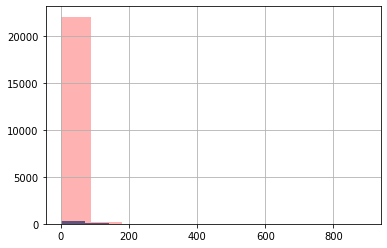

In [24]:
DF[DF.target==1].session_count.hist()
DF[DF.target==0].session_count.hist(alpha=0.3,color='red')

In [25]:
Engagement=pd.DataFrame(pd.pivot_table(Sessions, index='user_id', columns=Sessions.date.dt.week, aggfunc='count'))
Engagement.fillna(0, inplace=True)
Engagement=Engagement.iloc[:,:11]
Engagement.columns=['week '+str(i) for i in list(range(1,12))]
Engagement

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """Entry point for launching an IPython kernel.


,week 1,week 2,week 3,week 4,week 5,week 6,week 7,week 8,week 9,week 10,week 11
user_id,,,,,,,,,,,
6,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,0.0,24.0,17.0,24.0,1.0,1.0,7.0,0.0,0.0,0.0,0.0
22,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
22543,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22550,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22557,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
"""
# for monthly engagement 
Engagement=pd.DataFrame(pd.pivot_table(Sessions, index='user_id', columns=Sessions.date.dt.month, aggfunc='count'))
Engagement=Engagement.iloc[:,6:9]
Engagement.fillna(0, inplace=True)
Engagement.columns=['month '+str(i) for i in list(range(1,4))]
Engagement
"""

"\n# for monthly engagement \nEngagement=pd.DataFrame(pd.pivot_table(Sessions, index='user_id', columns=Sessions.date.dt.month, aggfunc='count'))\nEngagement=Engagement.iloc[:,6:9]\nEngagement.fillna(0, inplace=True)\nEngagement.columns=['month '+str(i) for i in list(range(1,4))]\nEngagement\n"

In [27]:
DF=pd.merge(DF, Engagement, on='user_id', how='left')
DF.head()

,user_id,install_date,lang,country,hw_ver,os_ver,session_count,Revenue,Purchsae_Date,chapterPasses,gems,valuePack,days_to_Purchase,target,week_day,week 1,week 2,week 3,week 4,week 5,week 6,week 7,week 8,week 9,week 10,week 11
0,0,2019-03-01,en,US,"iPhone4,1",9.1,0.0,0.0,1970-01-01,0.0,0.0,0.0,N/A,0,Friday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2019-03-01,en,IN,"iPod5,1",8.1.2,0.0,0.0,1970-01-01,0.0,0.0,0.0,N/A,0,Friday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2019-03-06,en,US,"iPod7,1",8.4.1,0.0,0.0,1970-01-01,0.0,0.0,0.0,N/A,0,Wednesday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2019-03-03,nb,NO,"iPhone8,1",9.2.1,0.0,0.0,1970-01-01,0.0,0.0,0.0,N/A,0,Sunday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2019-03-03,en,GB,"iPhone5,4",9.2.1,0.0,0.0,1970-01-01,0.0,0.0,0.0,N/A,0,Sunday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
#checking DF variables

for column in DF.columns:
  print('{:22}'.format(column) ,'\t', pd.api.types.infer_dtype(DF[column]))

user_id                	 integer
install_date           	 datetime64
lang                   	 string
country                	 mixed-integer
hw_ver                 	 string
os_ver                 	 string
session_count          	 floating
Revenue                	 floating
Purchsae_Date          	 datetime64
chapterPasses          	 floating
gems                   	 floating
valuePack              	 floating
days_to_Purchase       	 mixed-integer
target                 	 integer
week_day               	 string
week 1                 	 floating
week 2                 	 floating
week 3                 	 floating
week 4                 	 floating
week 5                 	 floating
week 6                 	 floating
week 7                 	 floating
week 8                 	 floating
week 9                 	 floating
week 10                	 floating
week 11                	 floating


In [29]:
# country has mixed data
no_country=DF[DF.country==0].index
DF=DF[~DF.index.isin(no_country)]

In [30]:
DF.groupby('week_day').target.sum()

week_day
Friday       35
Monday       41
Saturday     34
Sunday       40
Thursday     53
Tuesday      55
Wednesday    71
Name: target, dtype: int64

In [31]:
DF.head()

,user_id,install_date,lang,country,hw_ver,os_ver,session_count,Revenue,Purchsae_Date,chapterPasses,gems,valuePack,days_to_Purchase,target,week_day,week 1,week 2,week 3,week 4,week 5,week 6,week 7,week 8,week 9,week 10,week 11
0,0,2019-03-01,en,US,"iPhone4,1",9.1,0.0,0.0,1970-01-01,0.0,0.0,0.0,N/A,0,Friday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2019-03-01,en,IN,"iPod5,1",8.1.2,0.0,0.0,1970-01-01,0.0,0.0,0.0,N/A,0,Friday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2019-03-06,en,US,"iPod7,1",8.4.1,0.0,0.0,1970-01-01,0.0,0.0,0.0,N/A,0,Wednesday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2019-03-03,nb,NO,"iPhone8,1",9.2.1,0.0,0.0,1970-01-01,0.0,0.0,0.0,N/A,0,Sunday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2019-03-03,en,GB,"iPhone5,4",9.2.1,0.0,0.0,1970-01-01,0.0,0.0,0.0,N/A,0,Sunday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
"""
define dependent value (Target , and dependent values)

[ 'country', 'session_count', 'week 1',
       'week 2', 'week 3', 'week 4', 'week 5', 'week 6', 'week 7', 'week 8',
       'week 9', 'week 10', 'week 11', 'model'],


"""


y=DF.target
X=DF.iloc[:,[3,4,14,15,16,17,18,19,20,21,22,23,24,25]]
X.fillna(0, inplace=True)
X.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


,country,hw_ver,week_day,week 1,week 2,week 3,week 4,week 5,week 6,week 7,week 8,week 9,week 10,week 11
0,US,"iPhone4,1",Friday,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,IN,"iPod5,1",Friday,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,US,"iPod7,1",Wednesday,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NO,"iPhone8,1",Sunday,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,GB,"iPhone5,4",Sunday,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
from sklearn import set_config
set_config(display='diagram')
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.preprocessing import  MinMaxScaler , OneHotEncoder
from sklearn.pipeline import Pipeline ,make_pipeline


# select columns by data type
num_cols = make_column_selector(dtype_include='number')
cat_cols = make_column_selector(dtype_exclude='number')

scaler=MinMaxScaler()
ohe=OneHotEncoder(handle_unknown='ignore')



preprocessor = make_column_transformer(
    (make_pipeline(scaler), num_cols),
    (make_pipeline(ohe), cat_cols))





In [36]:
from sklearn.naive_bayes import MultinomialNB , BernoulliNB 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, RepeatedKFold , ShuffleSplit, RepeatedStratifiedKFold, cross_val_score
# create a pipeline

clf1=BernoulliNB()
clf2=RandomForestClassifier(random_state=1)
# create the Pipeline
pipe = Pipeline([('preprocessor', preprocessor), ('classifier', clf1)])


display(pipe)

params1 = {}

params1['classifier'] = [clf1]




# create the parameter dictionary for clf2
params2 = {}
params2['classifier__n_estimators'] = [100, 200]
params2['classifier__min_samples_leaf'] = [1, 2]
params2['classifier'] = [clf2]

# create a list of parameter dictionaries
params = [params1, params2]




RSKfold=RepeatedStratifiedKFold(n_splits=4, n_repeats=3)
# this will search every parameter combination within each dictionary

grid = GridSearchCV(pipe,params,cv=RSKfold, scoring='accuracy')
grid.fit(X, y)
grid.best_params_ , grid.best_score_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc664f4c650>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc673ade1d0>)])),
                ('classifier', BernoulliNB())])

({'classifier': RandomForestClassifier(min_samples_leaf=2, random_state=1),
  'classifier__min_samples_leaf': 2,
  'classifier__n_estimators': 100},
 0.9854192519056907)

In [35]:
# metric=Specifity


from sklearn.naive_bayes import MultinomialNB , BernoulliNB 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, RepeatedKFold , ShuffleSplit, RepeatedStratifiedKFold, cross_val_score
# create a pipeline

clf1=BernoulliNB()
clf2=RandomForestClassifier(random_state=1)
# create the Pipeline
pipe = Pipeline([('preprocessor', preprocessor), ('classifier', clf1)])


display(pipe)

params1 = {}

params1['classifier'] = [clf1]




# create the parameter dictionary for clf2
params2 = {}
params2['classifier__n_estimators'] = [100, 200]
params2['classifier__min_samples_leaf'] = [1, 2]
params2['classifier'] = [clf2]

# create a list of parameter dictionaries
params = [params1, params2]

Specificity=make_scorer(recall_score, pos_label=1)


RSKfold=RepeatedStratifiedKFold(n_splits=4, n_repeats=3)
# this will search every parameter combination within each dictionary

grid = GridSearchCV(pipe,params,cv=RSKfold, scoring=Specificity)
grid.fit(X, y)
grid.best_params_ , grid.best_score_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc664f4c650>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc673ade1d0>)])),
                ('classifier', BernoulliNB())])

({'classifier': BernoulliNB()}, 0.34939759036144574)

# Markov Chain Model 

## Transition Matrix

In [ ]:
import numpy as np
import matplotlib.patches as mpatches 
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt

class Node():
    
    def __init__(
        self, center, radius, label, 
        facecolor='#2693de', edgecolor='#e6e6e6',
        ring_facecolor='#a3a3a3', ring_edgecolor='#a3a3a3'
        ):
        """
        Initializes a Markov Chain Node(for drawing purposes)
        Inputs:
            - center : Node (x,y) center
            - radius : Node radius
            - label  : Node label
        """
        self.center = center
        self.radius = radius
        self.label  = label

        # For convinience: x, y coordinates of the center
        self.x = center[0]
        self.y = center[1]
        
        # Drawing config
        self.node_facecolor = facecolor
        self.node_edgecolor = edgecolor
        
        self.ring_facecolor = ring_facecolor
        self.ring_edgecolor = ring_edgecolor
        self.ring_width = 0.03  
        
        self.text_args = {
            'ha': 'center', 
            'va': 'center', 
            'fontsize': 16
        }
    
    
    def add_circle(self, ax):
        """
        Add the annotated circle for the node
        """
        circle = mpatches.Circle(self.center, self.radius)
        p = PatchCollection(
            [circle], 
            edgecolor = self.node_edgecolor, 
            facecolor = self.node_facecolor
        )
        ax.add_collection(p)
        ax.annotate(
            self.label, 
            xy = self.center, 
            color = '#ffffff', 
            **self.text_args
        )
        
        
    def add_self_loop(self, ax, prob=None, direction='up'):
        """
        Draws a self loop
        """
        if direction == 'up':
            start = -30
            angle = 180
            ring_x = self.x
            ring_y = self.y + self.radius
            prob_y = self.y + 1.3*self.radius
            x_cent = ring_x - self.radius + (self.ring_width/2)
            y_cent = ring_y - 0.15
        else:
            start = -210
            angle = 0
            ring_x = self.x
            ring_y = self.y - self.radius
            prob_y = self.y - 1.4*self.radius
            x_cent = ring_x + self.radius - (self.ring_width/2)
            y_cent = ring_y + 0.15
            
        # Add the ring
        ring = mpatches.Wedge(
            (ring_x, ring_y), 
            self.radius, 
            start, 
            angle, 
            width = self.ring_width
        )
        # Add the triangle (arrow)
        offset = 0.2
        left   = [x_cent - offset, ring_y]
        right  = [x_cent + offset, ring_y]
        bottom = [(left[0]+right[0])/2., y_cent]
        arrow  = plt.Polygon([left, right, bottom, left])

        p = PatchCollection(
            [ring, arrow], 
            edgecolor = self.ring_edgecolor, 
            facecolor = self.ring_facecolor
        )
        ax.add_collection(p)
        
        # Probability to add?
        if prob:
            ax.annotate(str(prob), xy=(self.x, prob_y), color='#000000', **self.text_args)

In [ ]:
# MArkov chain code


import numpy as np
import matplotlib.patches as mpatches 
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt

# module from this repository
#from node import Node

class MarkovChain:

    def __init__(self, M, labels):
        """
        Initializes a Markov Chain (for drawing purposes)
        Inputs:
            - M         Transition Matrix
            - labels    State Labels
        """

        if M.shape[0] < 2:
            raise Exception("There should be at least 2 states")
        if M.shape[0] > 4:
            raise Exception("Only works with 4 states max for now")
        if M.shape[0] != M.shape[1]:
            raise Exception("Transition matrix should be square")
        if M.shape[0] != len(labels):
            raise Exception("There should be as many labels as states")

        self.M = M
        self.n_states = M.shape[0]
        self.labels = labels

        # Colors
        self.arrow_facecolor = '#a3a3a3'
        self.arrow_edgecolor = '#a3a3a3'

        self.node_facecolor = '#2693de'
        self.node_edgecolor = '#e6e6e6'

        # Drawing config
        self.node_radius = 0.5
        self.arrow_width = 0.03
        self.arrow_head_width = 0.20
        self.text_args = {
            'ha': 'center',
            'va': 'center',
            'fontsize': 16
        }

        # Build the network
        self.build_network()


    def set_node_centers(self):
        """
        Positions the node centers given the number of states
        """
        # Node positions
        self.node_centers = []

        if self.n_states == 2:
            self.figsize = (10, 4)
            self.xlim = (-5, 5)
            self.ylim = (-2, 2)
            self.node_centers = [[-4,0], [4,0]]
        elif self.n_states == 3:
            self.figsize = (10, 6)
            self.xlim = (-5, 5)
            self.ylim = (-3, 3)
            self.node_centers = [[-3,-2], [3,-2], [-3,2]]
        elif self.n_states == 4:
            self.figsize = (8, 8)
            self.xlim = (-5, 5)
            self.ylim = (-5, 5)
            self.node_centers = [[-4,4], [4,4], [4,-4], [-4,-4]]


    def build_network(self):
        """
        Loops through the matrix, add the nodes
        """
        # Position the node centers
        self.set_node_centers()

        # Set the nodes
        self.nodes = []
        for i in range(self.n_states):
            node = Node(
                self.node_centers[i],
                self.node_radius,
                self.labels[i]
            )
            self.nodes.append(node)


    def add_arrow(self, ax, node1, node2, prob=None):
        """
        Add a directed arrow between two nodes
        """
        # x,y start of the arrow
        x_start = node1.x + np.sign(node2.x-node1.x) * node1.radius
        y_start = node1.y + np.sign(node2.y-node1.y) * node1.radius

        # arrow length
        dx = abs(node1.x - node2.x) - 2.5* node1.radius
        dy = abs(node1.y - node2.y) - 2.5* node1.radius

        # we don't want xoffset and yoffset to both be non-nul
        yoffset = 0.4 * self.node_radius * np.sign(node2.x-node1.x)
        if yoffset == 0:
            xoffset = 0.4 * self.node_radius * np.sign(node2.y-node1.y)
        else:
            xoffset = 0

        arrow = mpatches.FancyArrow(
            x_start + xoffset,
            y_start + yoffset,
            dx * np.sign(node2.x-node1.x),
            dy * np.sign(node2.y-node1.y),
            width = self.arrow_width,
            head_width = self.arrow_head_width
        )
        p = PatchCollection(
            [arrow],
            edgecolor = self.arrow_edgecolor,
            facecolor = self.arrow_facecolor
        )
        ax.add_collection(p)

        # Probability to add?
        x_prob = x_start + xoffset + 0.2*dx*np.sign(node2.x-node1.x)
        y_prob = y_start + yoffset + 0.2*dy*np.sign(node2.y-node1.y)
        if prob:
            ax.annotate(str(prob), xy=(x_prob, y_prob), color='#000000', **self.text_args)


    def draw(self, img_path=None):
        """
        Draw the Markov Chain
        """
        fig, ax = plt.subplots(figsize=self.figsize)

        # Set the axis limits
        plt.xlim(self.xlim)
        plt.ylim(self.ylim)

        # Draw the nodes
        for node in self.nodes:
            node.add_circle(ax)

        # Add the transitions
        for i in range(self.M.shape[0]):
            for j in range(self.M.shape[1]):
                # self loops
                if i == j:
                    # Loop direction
                    if self.nodes[i].y >= 0:
                        self.nodes[i].add_self_loop(ax, prob = self.M[i,j], direction='up')
                    else:
                        self.nodes[i].add_self_loop(ax, prob = self.M[i,j], direction='down')
                # directed arrows
                elif self.M[i,j] > 0:
                    self.add_arrow(ax, self.nodes[i], self.nodes[j], prob = self.M[i,j])

        plt.axis('off')
        # Save the image to disk?
        if img_path:
            plt.savefig(img_path)
        plt.show()




In [ ]:
Sessions['month']=Sessions.date.dt.month
Session_temp=Sessions[["user_id", 'month','session_num']]
MARKOV=pd.pivot_table(Session_temp, index='user_id', columns='month', aggfunc='count')
MARKOV=pd.DataFrame(MARKOV)
MARKOV.columns=['March','April','May']
MARKOV.fillna(0, inplace=True)
MARKOV

,March,April,May
user_id,,,
0,12.0,0.0,0.0
1,34.0,0.0,0.0
2,33.0,6.0,0.0
3,3.0,0.0,0.0
4,3.0,0.0,0.0
...,...,...,...
22571,4.0,0.0,0.0
22572,5.0,0.0,0.0
22573,14.0,2.0,0.0


In [ ]:
purchases=iaps[["user_id", 'date','rev']]
Purchases=pd.pivot_table(purchases, index='user_id', columns=purchases.date.dt.month, aggfunc='sum')
Purchases.columns=['rev_March', 'rev_April','rev_May' ]
Purchases.fillna(0, inplace=True)
Purchases

,rev_March,rev_April,rev_May
user_id,,,
2,760.0,0.0,0.0
21,2280.0,0.0,0.0
36,4560.0,0.0,0.0
51,5380.0,1170.0,0.0
85,0.0,760.0,0.0
...,...,...,...
22528,4850.0,0.0,0.0
22536,1520.0,0.0,0.0
22544,1170.0,820.0,0.0


In [ ]:
Transitions=pd.merge(MARKOV, Purchases, on='user_id', how='left')
Transitions.fillna(0, inplace=True)
Transitions

,March,April,May,rev_March,rev_April,rev_May
user_id,,,,,,
0,12.0,0.0,0.0,0.0,0.0,0.0
1,34.0,0.0,0.0,0.0,0.0,0.0
2,33.0,6.0,0.0,760.0,0.0,0.0
3,3.0,0.0,0.0,0.0,0.0,0.0
4,3.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
22571,4.0,0.0,0.0,0.0,0.0,0.0
22572,5.0,0.0,0.0,0.0,0.0,0.0
22573,14.0,2.0,0.0,0.0,0.0,0.0


In [ ]:
# create cluster based on revenue and activities
# A for positive revenue and positive sessions_num
# B for no revenue and only played
# C for less than 3 times played

Transitions['March_Cluster']=Transitions[['March','rev_March']]\
                            .apply(lambda x: 'A' if(x[0]>0 and x[1]>0) else ('B' if x[0]>3 else 'C'), axis=1)


Transitions['April_Cluster']=Transitions[['April','rev_April']]\
                            .apply(lambda x: 'A' if(x[0]>0 and x[1]>0) else ('B' if x[0]>3 else 'C'), axis=1)


Transitions['May_Cluster']=Transitions[['May','rev_May']]\
                            .apply(lambda x: 'A' if(x[0]>0 and x[1]>0) else ('B' if x[0]>3 else 'C'), axis=1)


Transitions

,March,April,May,rev_March,rev_April,rev_May,March_Cluster,April_Cluster,May_Cluster
user_id,,,,,,,,,
0,12.0,0.0,0.0,0.0,0.0,0.0,B,C,C
1,34.0,0.0,0.0,0.0,0.0,0.0,B,C,C
2,33.0,6.0,0.0,760.0,0.0,0.0,A,B,C
3,3.0,0.0,0.0,0.0,0.0,0.0,C,C,C
4,3.0,0.0,0.0,0.0,0.0,0.0,C,C,C
...,...,...,...,...,...,...,...,...,...
22571,4.0,0.0,0.0,0.0,0.0,0.0,B,C,C
22572,5.0,0.0,0.0,0.0,0.0,0.0,B,C,C
22573,14.0,2.0,0.0,0.0,0.0,0.0,B,C,C


In [ ]:

# now values for markov chain transition matrix

# Clsuter A

Cluster_A=list(Transitions[["March_Cluster","April_Cluster"]].\
        apply(lambda x: 'A' if(x[0]=='A'and x[1]=='A') else ('B'if x[0]=='A'and x[1]=='B' else ('C'if x[0]=='A'and x[1]=='C'else 0)), axis=1).values)

n=list(Transitions[["March_Cluster"]].values).count('A')
#Transition Rate
Cluster_A_to_A=Cluster_A.count('A')/n

Cluster_A_to_B=Cluster_A.count('B')/n

Cluster_A_to_C=Cluster_A.count('C')/n

In [ ]:
# some of all probability should be 1
print(sum([Cluster_A_to_C,Cluster_A_to_B ,Cluster_A_to_A ]))
Cluster_A_to_A , Cluster_A_to_B , Cluster_A_to_C

1.0


(0.09735744089012517, 0.16968011126564672, 0.7329624478442281)

In [ ]:
# now values for markov chain transition matrix

# Clsuter B

Cluster_B=list(Transitions[["March_Cluster","April_Cluster"]].\
        apply(lambda x: 'B' if(x[0]=='B'and x[1]=='B') else ('A' if (x[0]=='B'and x[1]=='A') else ('C' if x[0]=='B'and x[1]=='C'else 0)), axis=1).values)

n=list(Transitions[["March_Cluster"]].values).count('B')
#Transition Rate
Cluster_B_to_B=Cluster_B.count('B')/n

Cluster_B_to_A=Cluster_B.count('A')/n

Cluster_B_to_C=Cluster_B.count('C')/n

In [ ]:
print(sum([ Cluster_B_to_B , Cluster_B_to_A ,Cluster_B_to_C ]))
Cluster_B_to_A , Cluster_B_to_B , Cluster_B_to_C

1.0


(0.005549722513874306, 0.18546572671366432, 0.8089845507724613)

In [ ]:


# Clsuter C

Cluster_C=list(Transitions[["March_Cluster","April_Cluster"]].\
        apply(lambda x: 'C' if(x[0]=='C'and x[1]=='C') else ('A' if (x[0]=='C'and x[1]=='A') else ('B' if x[0]=='C'and x[1]=='B'else 0)), axis=1).values)

n=list(Transitions[["March_Cluster"]].values).count('C')
#Transition Rate
Cluster_C_to_B=Cluster_C.count('B')/n

Cluster_C_to_A=Cluster_C.count('A')/n

Cluster_C_to_C=Cluster_C.count('C')/n

In [ ]:
print(sum([Cluster_C_to_A , Cluster_C_to_B , Cluster_C_to_C]))
Cluster_C_to_A , Cluster_C_to_B , Cluster_C_to_C

1.0


(0.0009006690684508493, 0.020329387545033453, 0.9787699433865157)

In [ ]:
C=[round(i,3) for i in [Cluster_C_to_C,Cluster_C_to_B ,Cluster_C_to_A  ]]
B=[round(i,3) for i in [ Cluster_B_to_C,Cluster_B_to_B , Cluster_B_to_A   ]]
A=[round(i,3) for i in [Cluster_A_to_C,Cluster_A_to_B ,Cluster_A_to_A ]]

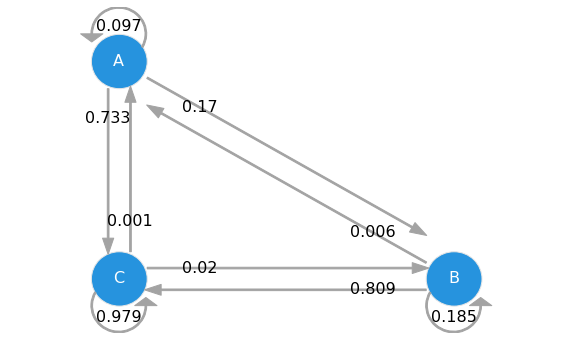

In [ ]:


import numpy as np
import matplotlib.pyplot as plt 
# Import the MarkovChain class from markovchain.py
#from markovchain import MarkovChain
P = np.array([C,B,A]) 

# Transition matrix



mc = MarkovChain(P, ['C', 'B','A'])
mc.draw()